In [13]:
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
# Trouve les indexes des premieres 'n' valeurs minimales d'une matrice
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}
cosinus.vm <- function(v,m) { 
    n <- sqrt(colSums(m^2)); 
    (v %*% m)/(n * sqrt(sum(v^2)))
}

colMeans.sparse <- function(m) {colSums(m)/colSums(m>0)}
rowMeans.sparse <- function(m) {rowSums(m)/rowSums(m>0)}
means.sparse <- function(v) {sum(v)/sum(v>0)}

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
m.na.t <- t(m.na)
m.t <- t(m)
m.sparse.t <- t(m.sparse)

In [14]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b], m.na[i.test.b])
    }
to.plot <- c()
cv.b <- c()

In [15]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
cv.b <- c()

for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
    
# Question 7 - Validation croisée pour question 3
# Ici nous essayons de prédire les valeurs des votes du film Star trek 5 à l'aide d'une approche item-item
m.sparse <- m
m.sparse[i.test.b]<-0
m.sparse.t <- t(m.sparse)
try <- function(x,y,w) {x.0 <- x>0 ; x.temp <- (x-y)*x.0; num <-  w %*%x.temp;denum <- sum(abs(t(w))*x.0);num/denum} 

film_pred <- function(film_id){
# Pour l'exercise, on choisit de prendre seulement les utilisateurs pour l'item Star Trek V: The Final Frontier
v.item <- m.sparse.t[film_id,]
new.m.sparse <- m.sparse

voisins <- 21
# on centre la matrice m selon les utilisateurs
# on calcule la moyenne et centré pour enlever les biais des utilisateurs comme pour la question 4
u.mean <-rowMeans.sparse(new.m.sparse)
m.center <- as.matrix((new.m.sparse-u.mean)*(new.m.sparse>0))
# on remplace les 0 par NA
m.center[m.center==0] <- NA

# on calcule la distance eucledienne entre les films
distance.na.450.center <- sqrt(colSums((m.center[,film_id] - m.center)^2, na.rm=T)) # ignore les valeurs manquantes
# on calcule le nombre de votes communs des films avec star trek V
votes.communs <- (colSums((new.m.sparse[,film_id] * new.m.sparse) > 0))
# on assigne la valeur au film qui ont moins de 40 votes communs avec star trek V
distance.na.450.center[votes.communs<5] <- Inf

closest.euc <- min.nindex(distance.na.450.center, voisins)[-1]

wcos.st <- cosinus.vm(new.m.sparse[,film_id], new.m.sparse[,closest.euc])

# les 20 films les plus communs
idx<- closest.euc
# on transpose m
m.sparse.t <- t(new.m.sparse)
# la range de l item de star trek V
v.item <- m.sparse.t[film_id,]
# la moyenne de l item de star trek V
v_1 <-means.sparse(v.item);
# retourne la moyenne pour chacun des 20 films voisisns
v_i <- apply(m.sparse.t[idx,], 1, FUN=means.sparse)

x<- as.matrix((m.sparse.t[idx,]))
new_x <-lapply(seq_len(ncol(x)), function(i) x[,i]) # Retourne une liste de longeur 943 
new_y <-as.vector(lapply(seq_len(ncol(x)), function(i) v_i)) 
new_w <-as.vector(lapply(seq_len(ncol(x)), function(i) as.matrix(wcos.st)))

    
c_prod <- mapply(try ,new_x, new_y, new_w)
# Ajoute la moyenne de l'item 
v_1+c_prod
}
film_prection_list <-lapply(seq_len(1682), film_pred) # Retourne une liste de longeur 943 
new.matrix <- do.call(cbind, film_prection_list)
new.matrix[!is.finite(new.matrix)]<- rep(rowMeans(new.matrix,na.rm=T),1682)[!is.finite(new.matrix)]
m.train <- new.matrix
mae.temp <- mae(new.matrix[i.test.b], m.na[i.test.b])
cv.b <- c(cv.b,mae.temp)
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
}

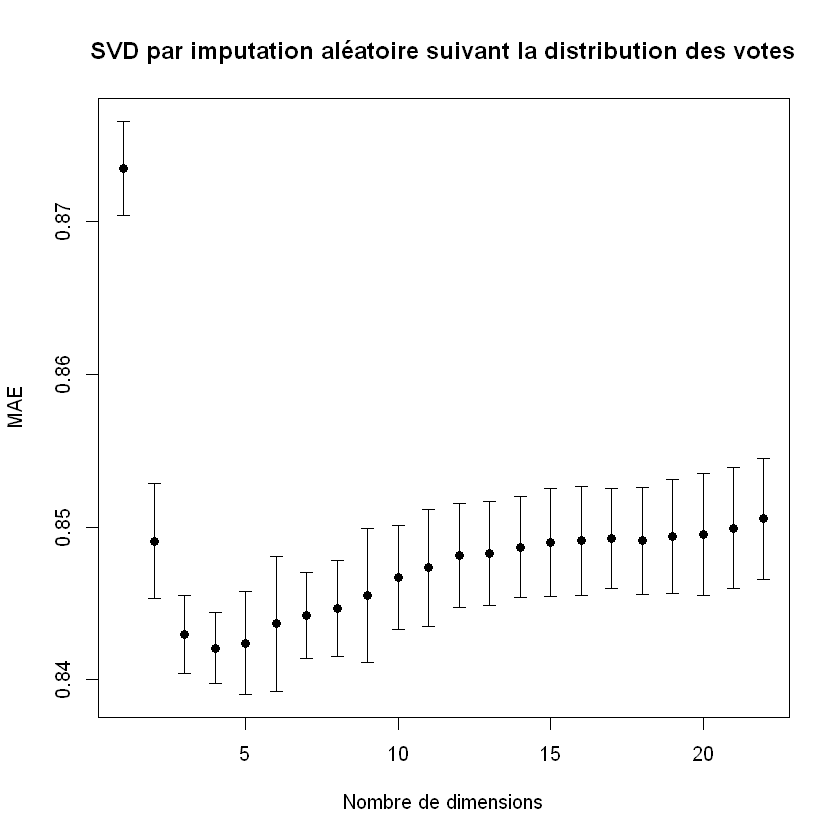

In [16]:
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg.cv <- mean(cv.b)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(avg-sdev, avg+sdev),pch=19, xlab="Nombre de dimensions", ylab="MAE",
    main="SVD par imputation aléatoire suivant la distribution des votes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [17]:
avg.cv

[1] 0.9589051